### Práctica 3: Bolsas de Términos, o BoW y Esquemas de Pesado
<p><kbd>0226594</kbd> Sara Carolina Gómez Delgado  </p>
<p>Clase de Procesamiento de Lenguaje Natural</p>

In [145]:
import nltk
import matplotlib
from sklearn.ensemble import RandomForestClassifier
import pandas
from bs4 import BeautifulSoup
import numpy
import scipy

In [146]:
def get_texts_from_file(path_corpus, path_truth):
    tr_txt = []
    tr_y = []
    with open(path_corpus, "r",encoding="utf8") as f_corpus, open(path_truth, "r",encoding="utf8") as f_truth:
        for tuit in f_corpus:
            tr_txt += [tuit]
        for label in f_truth:
            tr_y += [label] 
    return tr_txt, tr_y

In [147]:
tr_txt, tr_y = get_texts_from_file("./mex_train.txt", "./mex_train_labels.txt")

In [148]:
len(tr_txt)

5544

In [149]:
len(tr_y)

5544

In [150]:
# Split no funciona porque tenemos signos de puntuación y no sólo espacios.
tr_txt[5].split()

['putos.',
 'no',
 'tienen',
 'madre.',
 'ambriados',
 'mantenidos.',
 'ojetes.',
 'como',
 'es',
 'posible.',
 'mejor',
 'matarlos']

## Tokenizar un tuit

In [151]:
import nltk 
from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer()

In [152]:
tokenizer.tokenize(tr_txt[5])

['putos',
 '.',
 'no',
 'tienen',
 'madre',
 '.',
 'ambriados',
 'mantenidos',
 '.',
 'ojetes',
 '.',
 'como',
 'es',
 'posible',
 '.',
 'mejor',
 'matarlos']

In [153]:
corpus_palabras = []
for doc in tr_txt:
    corpus_palabras += tokenizer.tokenize(doc) # lista con documentos divididos por espacios (contando signos de puntuación)

In [154]:
len(set(corpus_palabras))

13580

In [155]:
fdist = nltk.FreqDist(corpus_palabras) # cuántas veces aparece cada palabra

In [156]:
def sortFreqDict(freqdict):
    aux = [(freqdict[key], key) for key in freqdict] #lista de pares ordenada (más frecuente a menos)
    aux.sort()
    aux.reverse()
    return aux #regresa el objeto ordenado en reversa

In [157]:
V = sortFreqDict(fdist)
V = V[:5000]
V[:10]

[(3383, 'que'),
 (3357, 'de'),
 (2774, '.'),
 (2629, 'a'),
 (2433, 'la'),
 (2266, 'y'),
 (1824, 'no'),
 (1613, 'me'),
 (1505, '!'),
 (1303, 'el')]

In [158]:
dict_indices = dict()
cont = 0
for weight, word in V:
    dict_indices[word]=cont
    cont+=1
print(len(dict_indices))

5000


In [159]:
list(dict_indices)[:5]

['que', 'de', '.', 'a', 'la']

In [160]:
val_txt, val_y = get_texts_from_file("./mex_val.txt", "./mex_val_labels.txt")

Counter({'0\n': 3563, '1\n': 1981})


Text(0.5, 0, 'Class')

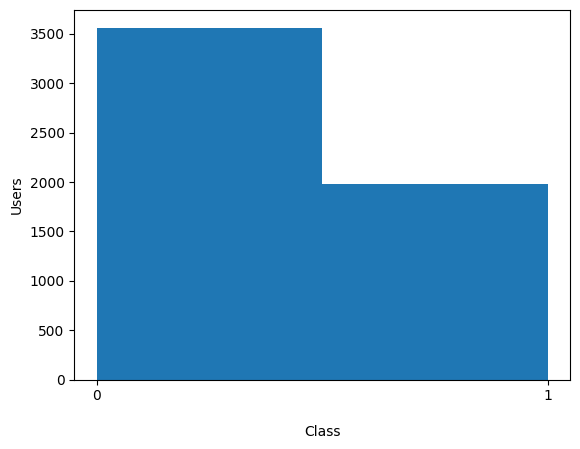

In [161]:
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

print(Counter(tr_y))

plt.hist(tr_y, bins=len(set(tr_y)))
plt.ylabel('Users')
plt.xlabel('Class')

Counter({'0\n': 397, '1\n': 219})


Text(0.5, 0, 'Class')

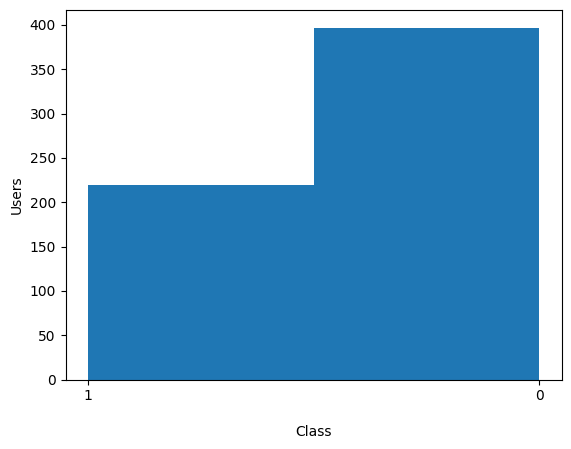

In [162]:
val_txt, val_y = get_texts_from_file('./mex_val.txt', "./mex_val_labels.txt")

from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

print(Counter(val_y))
plt.hist(val_y, bins=len(set(val_y)))

plt.ylabel('Users')
plt.xlabel('Class')

## Bag of Words (BOW)

In [163]:
import numpy as np
#   * tokenizer.tokenize(): recibe un tweet y lo separa de forma inteligente (por palabras). No se hace con split porque no sólo se separan por espacios
#   * FreqDist: mapa (regresa la frecuencia [cubetas de palabras])
#   * dict_indices: global (por todos los tweets [cubeta ordenada ascendente])


### <kbd>Binary</kbd>
* ¿Tiene la palabra? 1
* ¿no la tiene? 0

In [164]:
def binary_BOW(tweets, V, dict_indices): #string de tweets, vocabulario (frecuencia de palabras), diccionario de indices
    BOW = np.zeros((len(tweets),len(V)), dtype=int) #tweets * vocabulario  (si la palabra existe, pongo un 1 en mi matriz, si no, escribo un 0)
    for i, tweet in enumerate(tweets):
        word_map = nltk.FreqDist(tokenizer.tokenize(tweet))
        for word in word_map:
            if word in dict_indices:
                BOW[i, dict_indices[word]] = 1 
    return BOW  #bolsa de palabras (Número de documentos * número de palabras )
BOW_tr = binary_BOW(tr_txt, V, dict_indices)
print(BOW_tr[0,:])


[1 1 0 ... 0 0 0]


### <kbd>Term Frequency BoW</kbd>
* Cada casilla representa la frecuencia de la palabra

In [165]:
def freq_BOW(tweets, V, dict_indices):
    BOW = np.zeros((len(tweets),len(V)), dtype=int)
    for i, tweet in enumerate(tweets):
        word_map = nltk.FreqDist(tokenizer.tokenize(tweet))
        for word in word_map:
            if word in dict_indices:
                BOW[i, dict_indices[word]] = word_map[word]
    return BOW
BOW_tr = freq_BOW(tr_txt, V, dict_indices)
print(BOW_tr[0,:])

[1 2 0 ... 0 0 0]


### <kbd>TF-IDF BoW</kbd>

$$ w_{i,j} = tf(t_j, d_i) * idf(t_j) $$

$$  tf(t_j, d_i) =  frecuencia \hspace{1mm} de \hspace{1mm} t_j \hspace{1mm} en  \hspace{1mm} el \hspace{1mm} documento \hspace{1mm} d_i $$

$$ idf(t_j) = log(\frac{Num Documentos} {Num Docs \hspace{1mm} que \hspace{1mm} contienen \hspace{1mm} t_j }) $$




In [166]:
def tfidf_BOW(tweets, V, dict_indices):
    map_ = dict() #creo un "mapa" o diccionario para contar el número de documentos que contienen la palabra t_j
    BOW = np.zeros((len(tr_txt),len(V)), dtype=int)
    for i, tweet in enumerate(tweets):
        word_map = nltk.FreqDist(tokenizer.tokenize(tweet))
        for word in word_map:
            if word in dict_indices:
                if word in map_:
                    map_[word]+=1
                else:
                    map_[word] = 1 #inicializar el mapa 
                BOW[i, dict_indices[word]] = word_map[word] / len(tokenizer.tokenize(tweet))
    for i, tweet in enumerate(tweets):
        word_map = nltk.FreqDist(tokenizer.tokenize(tweet))
        for word in word_map:
            if word in dict_indices:
                BOW[i, dict_indices[word]] *= np.log( len(tweets) / map_[word])  # Ndocs = len(tweets) / Ndocs con t_j
    return BOW
BOW_tr = tfidf_BOW(tr_txt, V, dict_indices)
print(BOW_tr[0,:])

## Comparison 

In [ ]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV    
from sklearn import metrics 
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_fscore_support

parameters = {'C': [.05, .25, 1, 2]} # complejidad del algoritmo
svr = svm.LinearSVC(class_weight='balanced')
grid = GridSearchCV(estimator=svr, param_grid=parameters, n_jobs=8, scoring="f1_macro", cv=5)


def predVSreal(y_true, y_pred, BOW_tr, BOW_val):
    p, r, f, _ = precision_recall_fscore_support(y_true, y_pred, average = 'macro', pos_label = 1)
    print("****** SHAPES ******")
    print("Train:", BOW_tr.shape)
    print("Real:", BOW_val.shape)
    print("\n****** CONFUSION MATRIX ******")
    print(confusion_matrix(y_true, y_pred))
    print("\n****** CLASSIFICATION REPORT ******")
    print(metrics.classification_report(y_true, y_pred))

#### <kbd>Binary</kbd>

In [ ]:
BOW_tr = binary_BOW(tr_txt, V, dict_indices)
BOW_val = binary_BOW(val_txt, V, dict_indices)



# visualization 
grid.fit(BOW_tr, tr_y)
preds = grid.predict(BOW_val)

# confusion matrix & classification report
predVSreal(val_y, preds, BOW_tr, BOW_val)

****** SHAPES ******
Train: (5544, 5000)
Real: (616, 5000)

****** CONFUSION MATRIX ******
[[329  68]
 [ 47 172]]

****** CLASSIFICATION REPORT ******
              precision    recall  f1-score   support

          0
       0.88      0.83      0.85       397
          1
       0.72      0.79      0.75       219

    accuracy                           0.81       616
   macro avg       0.80      0.81      0.80       616
weighted avg       0.82      0.81      0.82       616



#### <kbd>Term Frequency BoW</kbd>


In [ ]:
BOW_val = freq_BOW(val_txt, V, dict_indices)
BOW_val.shape

(616, 5000)

#### <kbd>TF-IDF BoW</kbd>

In [ ]:
BOW_val = tfidf_BOW(val_txt, V, dict_indices)
BOW_val.shape

(5544, 5000)

In [ ]:



# tr_y = list(map(int,tr_y))
# grid.fit(BOW_tr, tr_y)
# val_y = list(map(int,val_y))
# y_pred = grid.predict(BOW_val)

# p,r,f,_ = precision_recall_fscore_support(val_y, y_pred, average="macro", pos_label=1)
# print(confusion_matrix(val_y, y_pred))
# print(metrics.classification_report(val_y, y_pred))

